In [39]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader

#%load_ext line_profiler

In [40]:
from model.eGauss_plus import eGAUSSp

In [41]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)


In [42]:
from utils.utils_dataset import balance_dataset
from utils.utils_dataset import prepare_dataset

device = torch.device("cpu")
num_clients = 4

proportion = 100
data = balance_dataset(data, proportion)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
client_train, test_data, all_data = prepare_dataset(X, y, num_clients) 


In [43]:

# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.1,
    "S_0": 1e-8,
    "c_max": 4,
    "device": torch.device("cpu")
}
federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-8,
    "c_max": 4,
    "device": torch.device("cpu")
}

# Initialize a model for each client
local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
federated_model = eGAUSSp(**federated_model_params)


Client 1: {0: 8629, 1: 67}
Client 2: {0: 8613, 1: 83}
Client 3: {0: 8600, 1: 96}
Client 4: {0: 8595, 1: 101}
Test Set: {0: 14763, 1: 145}

Combined Number of Samples per Class:
Class 0: 49200 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 49692


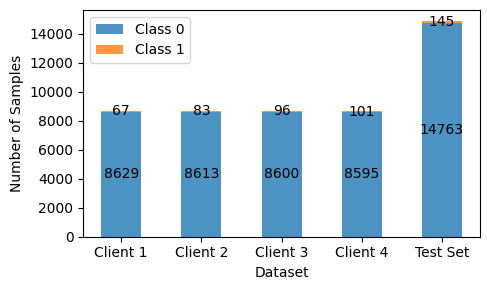

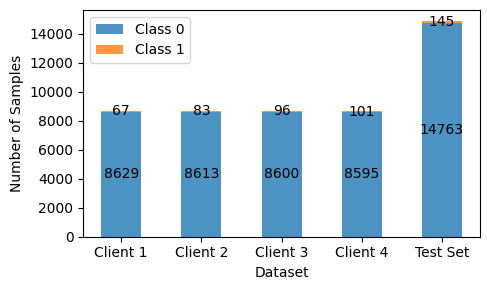

In [44]:
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split

display_dataset_split(client_train, test_data)
plot_dataset_split(client_train, test_data)

In [45]:
import utils.utils_train
from utils.utils_train import train_supervised, calculate_metrics, plot_confusion_matrix, calculate_roc_auc
from utils.utils_plots import plot_first_feature

if False:

    # Assuming models and client_data are already defined
    for client_idx, client_model in enumerate(local_models):
        print(f"Training model for client {client_idx + 1}")
        train_supervised(client_model, client_train[client_idx]) 
        plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  


In [46]:
import utils.utils_train
from utils.utils_train import train_models_in_threads
from utils.utils_plots import plot_first_feature

# Assuming local_models and client_train are already defined
# local_models is a list of models, client_train is a list of corresponding training datasets
train_models_in_threads(local_models, client_train)


Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.
Processed 1000 points.Number of clusters: 48
Processed 1000 points.Number of clusters: 45
Processed 1000 points.Number of clusters: 67
Processed 1000 points.Number of clusters: 59
Processed 2000 points.Number of clusters: 65
Processed 2000 points.Number of clusters: 64
Processed 2000 points.Number of clusters: 69
Processed 2000 points.Number of clusters: 64
Processed 3000 points.Number of clusters: 57
Processed 3000 points.Number of clusters: 74
Processed 3000 points.Number of clusters: 98
Processed 3000 points.Number of clusters: 77
Processed 4000 points.Number of clusters: 71
Processed 4000 points.Number of clusters: 82
Processed 4000 points.Number of clusters: 73
Processed 4000 points.Number of clusters: 85
Processed 5000 points.Number of clusters: 80
Processed 5000 points.Number of clusters: 80
Processed 5000 points.Number of clusters: 81
Processed 5000 points.Number of clust

In [47]:
from utils.utils_train import test_model   

# Testing each client's model on the global test dataset
for client_idx, client_model in enumerate(local_models):
    print(f"\nTesting model for client {client_idx + 1}")
    all_scores, pred_max = test_model(client_model, test_data)
    metrics = calculate_metrics(pred_max, test_data)
    #test_model(client_model, all_data)
    print(f"Test Metrics: {metrics}")
    
    


Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9691440837134424, 'precision': 0.9820411529027291, 'recall': 0.9691440837134424, 'f1_score': 0.9754078074446881}

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.95733834182989, 'precision': 0.9830381314564918, 'recall': 0.95733834182989, 'f1_score': 0.9695317408498288}

Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9543869063590019, 'precision': 0.9828075751378252, 'recall': 0.9543869063590019, 'f1_score': 0.9679027827304101}

Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.3759726321438154, 'precision': 0.9898764453710268, 'recall': 0.3759726321438154, 'f1_score': 0.5351504640229382}


In [48]:

for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} clusters = {torch.sum(client_model.n[:client_model.c]>1)}")
        federated_model.federal_agent.merge_model_privately(client_model, 1)

print(f"Number of clusters after transfer = {federated_model.c}")

Merging client 1
Number of client 1 clusters = 13
Merging client 2
Number of client 2 clusters = 10
Merging client 3
Number of client 3 clusters = 7
Merging client 4
Number of client 4 clusters = 6
Number of clusters after transfer = 36


In [49]:
from utils.utils_train import test_model

federated_model.federal_agent.federated_merging()
print(f"Number of clusters after merging = {federated_model.c}")


Number of clusters after merging = 9


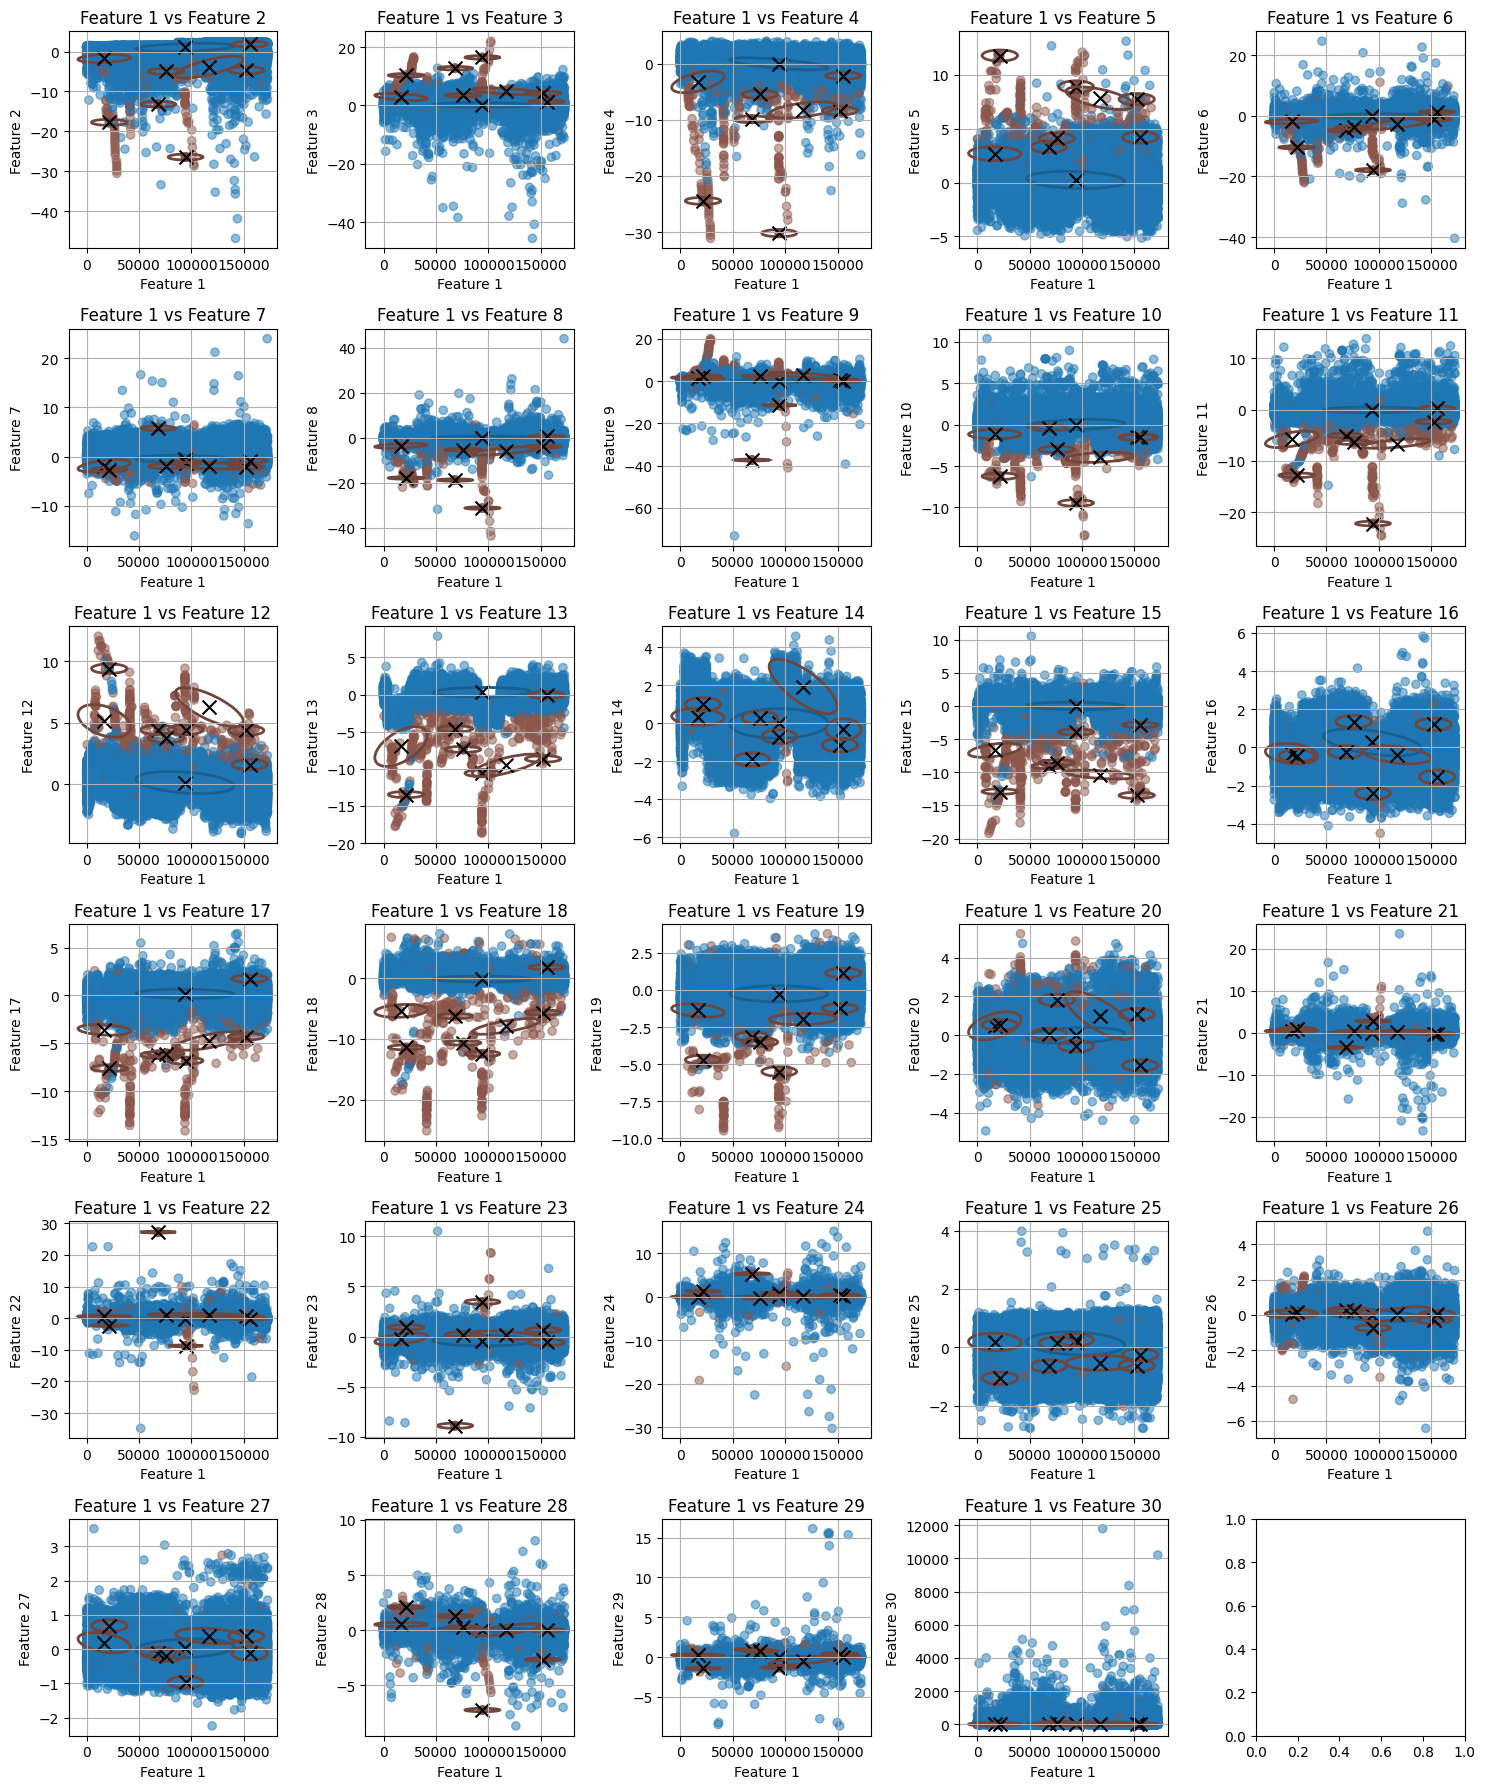


Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.48973705393077543, 'precision': 0.9898978553393512, 'recall': 0.48973705393077543, 'f1_score': 0.6470717648209343}
Test ROC AUC: 0.786271596979401


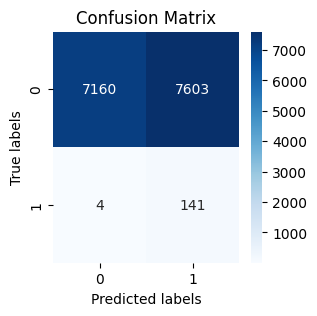

In [50]:

plot_first_feature(all_data, model=federated_model, num_sigma=2, N_max=1)   

print(f"\nTesting federated model")   

all_scores, pred_max = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data)
roc_auc = calculate_roc_auc(all_scores, test_data)
#test_model(client_model, all_data)
print(f"Test Metrics: {metrics}")
print(f"Test ROC AUC: {roc_auc}")
#test_model(federated_model, all_data)


plot_confusion_matrix(pred_max, test_data)